# Test out other models

In [34]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score, SCORERS
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm, tree
import xgboost
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import numpy as np

In [2]:
def save(clf, name):
    pickle_out = open(name,"wb")
    pickle.dump(clf, pickle_out)
    pickle_out.close()
    print ('Model ',name,' saved')


def load(clf_file):
    pickle_in = open(clf_file,"rb")
    clf = pickle.load(pickle_in)
    return clf

In [4]:
data = load('/Users/shiehan/Desktop/kaplan stuff/project5/data1.pkl')

In [5]:
X = data.drop(['Q6'], axis = 1)
y = data['Q6']
seed = 123
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [7]:
scaler = StandardScaler()
xtrain_val_scaled = scaler.fit_transform(X_train_val)
xtest_scaled = scaler.transform(X_test)

In [8]:
# these are the models I am testing out
classifiers = []
model1 = xgboost.XGBClassifier()
classifiers.append(model1)
model2 = svm.SVC()
classifiers.append(model2)
model3 = AdaBoostClassifier()
classifiers.append(model3)
model4 = RandomForestClassifier()
classifiers.append(model4)
model5 = lgb.LGBMClassifier()
classifiers.append(model5)

In [10]:
for model in classifiers:
    model.fit(xtrain_val_scaled, y_train_val)
    y_pred= model.predict(xtest_scaled)
    f1 = f1_score(y_test, y_pred, average= 'micro')
    print("F1_micro of %s is %s"%(model, f1))

    cm = confusion_matrix(y_test, y_pred)
    #print("Confusion Matrix of %s is %s"%(model, cm))

F1_micro of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) is 0.7981981981981981
F1_micro of SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) is 0.8000000000000002
F1_micro of AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None) is 0.6720720720720721
F1_micro of RandomForestClassifier(bootstrap

In [11]:
# Parameters tuning with SVC!
nfolds = 5
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    random_search = RandomizedSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds, n_iter=100,scoring='f1_micro', verbose=2,random_state = seed, n_jobs=-1)
    random_search.fit(X, y)
    random_search.best_params_
    return random_search.best_params_

In [12]:
print(svc_param_selection(xtrain_val_scaled, y_train_val, nfolds))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/shiehan/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished


{'gamma': 0.01, 'C': 10}


In [14]:
# SVM cross val with the best param
from sklearn.model_selection import cross_validate
svm_model = svm.SVC(kernel='rbf',gamma = 0.01, C = 10)
scores = cross_validate(svm_model, xtrain_val_scaled, y_train_val, cv=5, scoring='f1_micro')
scores

{'fit_time': array([0.13942504, 0.12839794, 0.13478494, 0.132653  , 0.13115501]),
 'score_time': array([0.02024293, 0.01792097, 0.02217412, 0.01887107, 0.02024698]),
 'test_score': array([0.79504505, 0.75675676, 0.74040632, 0.751693  , 0.76072235])}

In [15]:
print('f1_micro:',scores['test_score'].mean())


f1_micro: 0.7609246944461392


In [17]:
svm_model.fit(xtrain_val_scaled,y_train_val)
svm_pred = svm_model.predict(xtest_scaled)
print('f1_micro:',f1_score(y_test, svm_pred, average= 'micro'))


f1_micro: 0.7963963963963963


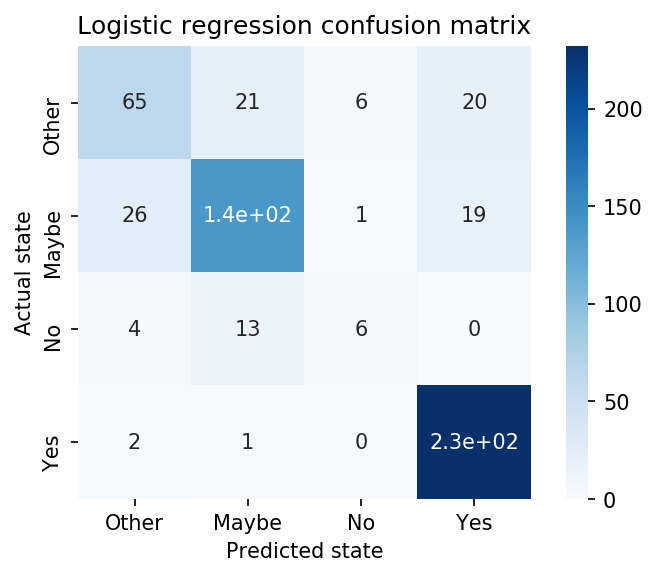

In [21]:
# print confusion matrix for SVC
logit_confusion = confusion_matrix(y_test, svm_model.predict(xtest_scaled))
plt.figure(dpi=150)
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=data['Q6'].unique(),
           yticklabels=data['Q6'].unique())

plt.xlabel('Predicted state')
plt.ylabel('Actual state')
plt.title('Logistic regression confusion matrix');

#plt.savefig("confusion_matrix_logit_data_IV")

In [22]:
# XGBClassifier param tuning!
def XGB_param_selection(X, y, nfolds):
    learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] 
    max_depth = [3, 4, 5, 6, 8, 10, 12, 15]
    min_child_weight = [1, 3, 5, 7]
    gamma = [0.0, 0.1, 0.2 , 0.3, 0.4]
    colsample_bytree = [0.3, 0.4, 0.5 , 0.7]
    param_grid = {'learning_rate': learning_rate, 'max_depth' : max_depth, 'min_child_weight': min_child_weight, 'gamma':gamma, 'colsample_bytree': colsample_bytree}
    random_search = RandomizedSearchCV(xgboost.XGBClassifier(objective='multi:softmax'), param_grid, cv=nfolds, n_iter=100,scoring='f1_micro', verbose=2,random_state = seed, n_jobs=-1)
    random_search.fit(X, y)
    random_search.best_params_
    return random_search.best_params_

In [23]:
print(XGB_param_selection(xtrain_val_scaled, y_train_val, nfolds))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.9min finished


{'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.3}


In [24]:
# XGBClassifier cross val with the best param

xgb_model = xgboost.XGBClassifier(objective='multi:softmax', min_child_weight= 7, max_depth= 3, learning_rate= 0.1, gamma= 0.4, colsample_bytree= 0.3)
scores = cross_validate(xgb_model, xtrain_val_scaled, y_train_val, cv=5, scoring='f1_micro')
scores

{'fit_time': array([0.591609  , 0.60122514, 0.63644505, 0.5835371 , 0.63985085]),
 'score_time': array([0.01683497, 0.0107739 , 0.01243067, 0.0093019 , 0.01149607]),
 'test_score': array([0.78603604, 0.75      , 0.72460497, 0.75395034, 0.75395034])}

In [25]:
print('f1_micro:',scores['test_score'].mean())

f1_micro: 0.7537083358753788


In [26]:
xgb_model.fit(xtrain_val_scaled,y_train_val)
xgb_pred = xgb_model.predict(xtest_scaled)
print('f1_micro:',f1_score(y_test, xgb_pred, average= 'micro'))


f1_micro: 0.7945945945945945


In [27]:
# LGB param tuning!
def lgb_param_selection(X, y, nfolds):
    bagging_fraction =  [0.5, 0.8]
    bagging_frequency = [5, 8]
    feature_fraction = [0.5, 0.8]
    max_depth = [10, 13]
    min_data_in_leaf = [90, 120]
    num_leaves = [1200, 1550]
    param_grid = {'bagging_fraction': bagging_fraction, 'bagging_frequency' : bagging_frequency, 
                  'feature_fraction':feature_fraction, 'max_depth':max_depth, 'min_data_in_leaf':min_data_in_leaf,
                 'num_leaves':num_leaves}
    random_search = RandomizedSearchCV(lgb.LGBMClassifier(objective = 'multiclass'), param_grid, cv=nfolds, n_iter=100,scoring='f1_micro', verbose=2,random_state = seed, n_jobs=-1)
    random_search.fit(X, y)
    random_search.best_params_
    return random_search.best_params_

In [28]:
print(lgb_param_selection(xtrain_val_scaled, y_train_val, nfolds))

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/Users/shiehan/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 64 is smaller than n_iter=100. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   36.4s finished


{'num_leaves': 1200, 'min_data_in_leaf': 120, 'max_depth': 10, 'feature_fraction': 0.8, 'bagging_frequency': 5, 'bagging_fraction': 0.5}


In [29]:
# LGBMClassifier cross val with the best params
lgbm_model = lgb.LGBMClassifier(objective = 'multiclass',num_leaves= 1200, min_data_in_leaf = 120, max_depth= 10, feature_fraction= 0.8, bagging_frequency= 5, bagging_fraction= 0.5)
scores = cross_validate(lgbm_model, xtrain_val_scaled, y_train_val, cv=5, scoring='f1_micro')
scores

{'fit_time': array([0.22064114, 0.20433617, 0.19534993, 0.19893813, 0.1909399 ]),
 'score_time': array([0.01867795, 0.01811576, 0.01664209, 0.01559401, 0.01563501]),
 'test_score': array([0.77927928, 0.75675676, 0.73363431, 0.751693  , 0.75395034])}

In [30]:
print('f1_micro:',scores['test_score'].mean())

f1_micro: 0.7550627376812479


In [31]:
lgbm_model.fit(xtrain_val_scaled,y_train_val)
lgbm_pred = lgbm_model.predict(xtest_scaled)
print('f1_micro:',f1_score(y_test, lgbm_pred, average= 'micro'))

f1_micro: 0.7927927927927928


In [32]:
rf = RandomForestClassifier(random_state = seed)
rf.fit(xtrain_val_scaled, y_train_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

Feature ranking:


Text(0.5, 0, 'Relative Importance')

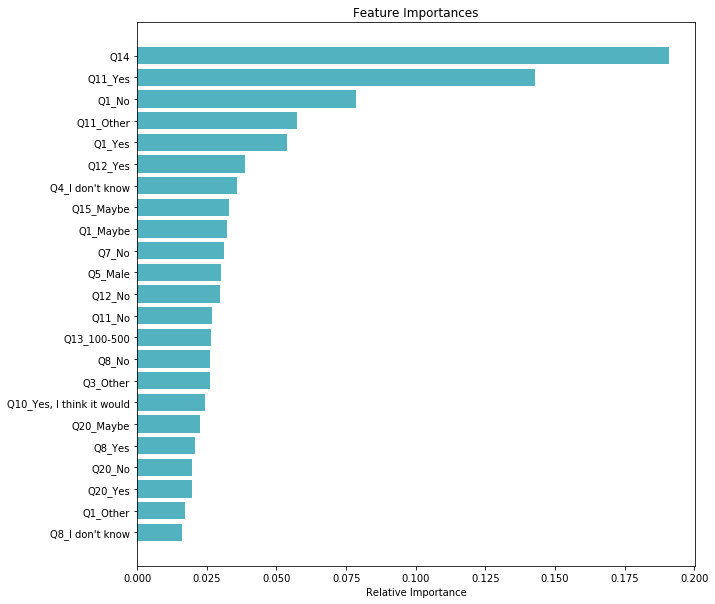

In [35]:
# Build a forest and compute the feature importances

features = data.drop(['Q6'],axis=1).columns
importances = rf.feature_importances_
importance_lst = list(zip(features,importances))
# Print the feature ranking
print("Feature ranking:")

indices = np.argsort(importances)
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#52B2BF', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

